In [53]:
import os
import pandas as pd
import random
import time

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [3]:
from collections import Counter

In [4]:
label_dict = {"Susceptible": 0, "Intermediate": 1, "Resistant":1}

In [658]:
df = pd.read_csv("staphylococcus_aureus/staphylococcus_gpa_cefoxitin_label.csv")
#Convert the string type labels to numeric entries
y = df["Resistant Phenotype"].map(label_dict).to_numpy()
genome_id = df["Genome ID"].to_list()

In [659]:
Counter(df["Resistant Phenotype"])

Counter({'Susceptible': 232, 'Resistant': 838})

In [660]:
df.drop(["Resistant Phenotype", "Genome ID"], axis=1, inplace=True)
df.head()

,spoVG,ilvD,arcB,mazG_2,group_1090,arcC,group_1149,group_1150,fadA,group_1312,...,group_9990,group_9991,group_9992,group_9993,group_9994,group_9995,group_9996,group_9997,group_9998,group_9999
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [661]:
X = df.to_numpy()

In [662]:
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.3, stratify=y )

In [663]:
Counter(y_train)

Counter({0: 162, 1: 587})

In [664]:
### Import the deep learning modules

In [665]:
import torch
import torch.nn.functional as F
import torch.optim as optim


from torch import nn
from torch.nn.functional import relu
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

In [666]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) #fix hash seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [667]:
random_seed = 42
seed_torch(random_seed)

In [668]:
###Define the Capsule Network here


In [669]:
class ConvCaps2D(nn.Module):
    def __init__(self):
        super(ConvCaps2D, self).__init__()
        self.capsules = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=primary_capslen,
                                                kernel_size=(1, ks), stride=stride) for _ in range(filters)])
        
    
    def squash(self, tensor, dim=1):
        norm=(tensor**2).sum(dim=dim, keepdim=True)
        scale=norm/(1+norm)
        return scale*tensor/torch.sqrt(norm)
    
    def forward(self, x):
        outputs = [capsule(x).view(x.size(0), primary_capslen, -1) for capsule in self.capsules] # 32 list of (None, 1, 8, 36)
        outputs = torch.cat(outputs, dim = 2).permute(0, 2, 1)  # outputs.size() is (None, 1152, 8)
        return self.squash(outputs)

In [670]:
class Caps1D(nn.Module):
    def __init__(self):
        super(Caps1D, self).__init__()
        self.num_iterations = num_iterations
        self.num_caps = 2 # equals to class number
        self.num_routes= (int((neurons-ks)/stride)+1)*filters
        self.in_channels=primary_capslen
        self.out_channels=digital_capslen

        self.W = nn.Parameter(torch.randn(self.num_caps,self.num_routes, self.in_channels, self.out_channels)) # class,weight,len_capsule,capsule_layer
#         self.W = nn.Parameter(torch.randn(3, 3136, 8, 32)) # num_caps, num_routes, in_channels, out_channels

    def softmax(self, x, dim = 1):
        transposed_input = x.transpose(dim, len(x.size()) - 1)
        softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)))
        return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(x.size()) - 1)

    def squash(self, tensor, dim=-1):
        norm = (tensor**2).sum(dim=dim, keepdim = True) # norm.size() is (None, 1152, 1)
        scale = norm / (1 + norm)
        return scale*tensor / torch.sqrt(norm)

    # Routing algorithm
    def forward(self, u):
        # u.size() is (None, 1152, 8)
        '''
        From documentation
        For example, if tensor1 is a j x 1 x n x m Tensor and tensor2 is a k x m x p Tensor,
        out will be an j x k x n x p Tensor.
        We need j = None, 1, n = 1152, k = 10, m = 8, p = 16
        '''

        u_ji = torch.matmul(u[:, None, :, None, :], self.W) # u_ji.size() is (None, 10, 1152, 1, 16)

        b = Variable(torch.zeros(u_ji.size())) # b.size() is (None, 10, 1152, 1, 16)
        b = b.to(device) # using gpu

        for i in range(self.num_iterations):
            c = self.softmax(b, dim=2)
            v = self.squash((c * u_ji).sum(dim=2, keepdim=True)) # v.size() is (None, 10, 1, 1, 16)

            if i != self.num_iterations - 1:
                delta_b = (u_ji * v).sum(dim=-1, keepdim=True)
                b = b + delta_b

        # Now we simply compute the length of the vectors and take the softmax to get probability.
        v = v.squeeze()
        classes = (v ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes)

        return classes

In [671]:
class CapsNet(nn.Module):
    def __init__(self):
#         super().__init__() #py3
        super(CapsNet, self).__init__() #py2
        self.fc1 = nn.Linear(top_k,neurons)  ##21653 because there are 21653 genes for S.aureus
        self.dropout1 = nn.Dropout(p=dropout)
        self.primaryCaps = ConvCaps2D()
        self.digitCaps = Caps1D()


    def forward(self, x):
        x = activation(self.dropout1(self.fc1(x)))
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        return x

In [672]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [673]:
from livelossplot import PlotLosses
from torchsummary import summary

In [674]:
def train_model(model, criterion, optimizer, num_epochs=20):
    liveloss = PlotLosses()
    model = model.to(device)

    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()

            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        scheduler.step()
        liveloss.update(logs)
        liveloss.draw()

In [675]:
neurons=150
dropout=0.5
primary_capslen=8
digital_capslen=32
ks=5
stride=2
filters=6
num_iterations=6#dynamic routing iterations

##
initial_lr=5e-1
batch_size=128
epochs=200
activation=relu
top_k = X.shape[1]

In [676]:
X_train=X_train.reshape(X_train.shape[0],1,1,top_k)
X_test=X_test.reshape(X_test.shape[0],1,1,top_k)

In [677]:
X_test.shape

(321, 1, 1, 21653)

In [678]:
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1./class_sample_count

samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

In [679]:
class_sample_count

array([162, 587])

In [680]:
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight), replacement=True)

In [681]:
trainloader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)),
                         batch_size=batch_size, sampler=sampler, shuffle=False)
testloader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)),
                         batch_size=batch_size, shuffle=False)

In [682]:
dataloaders = {
    "train": trainloader,
    "validation": testloader
}

In [683]:
model = CapsNet()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=initial_lr)
#scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.8)
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9)

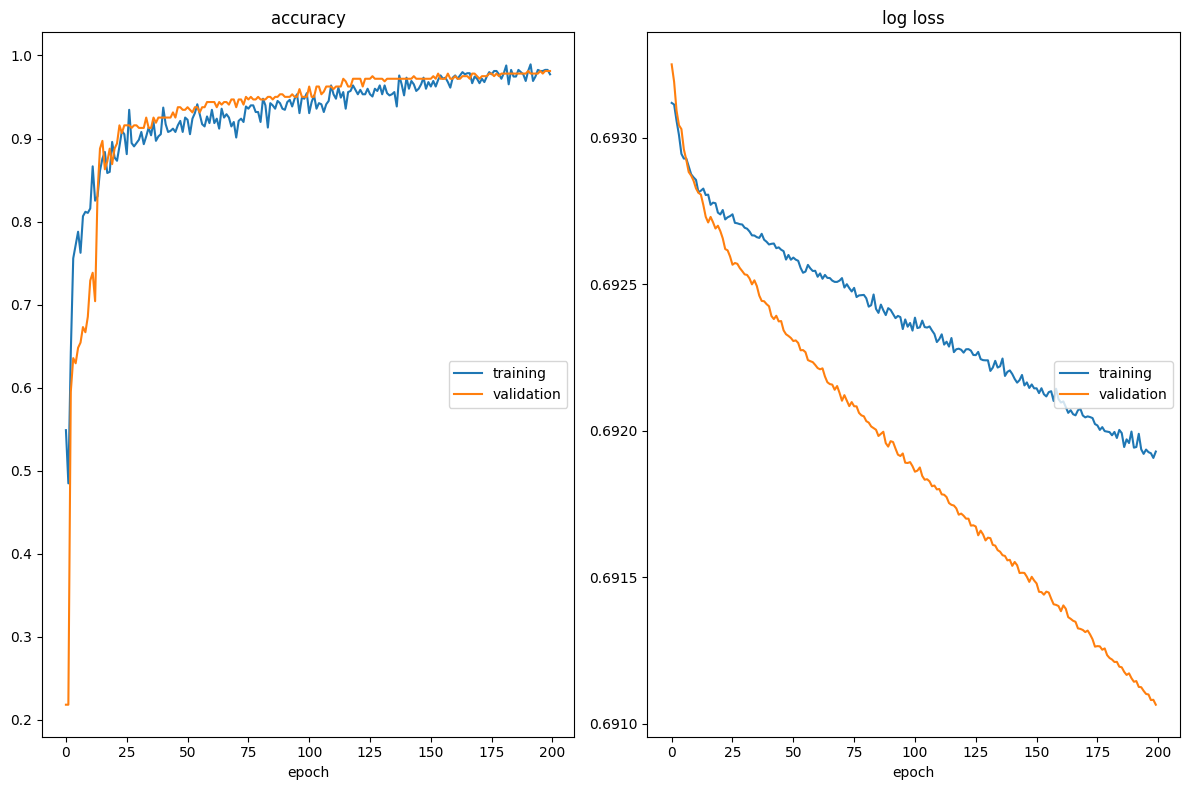

accuracy
	training         	 (min:    0.485, max:    0.989, cur:    0.977)
	validation       	 (min:    0.218, max:    0.981, cur:    0.981)
log loss
	training         	 (min:    0.692, max:    0.693, cur:    0.692)
	validation       	 (min:    0.691, max:    0.693, cur:    0.691)


In [684]:
train_model(model, criterion, optimizer, num_epochs=epochs)

In [685]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay

In [686]:
in_test=Variable(torch.tensor(X_test).to(device))
y_pred1 = model(torch.Tensor(X_test).cuda()).detach().cpu().numpy()
y_pred = np.argmax(y_pred1, axis=1)

#y_pred=np.concatenate([y_pred,y_pred1])
y_true = y_test

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()


acc = round((tp + tn) * 1. / (tp + fp + tn + fn),3)
precision = round(tp*1./(tp+fp),3)
recall = round(tp*1./(tp+fn),3)
f1=round(2*(precision*recall)/(precision+recall),3)

/tmp/ipykernel_175749/3741472792.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)))
/tmp/ipykernel_175749/3741472792.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  classes = F.softmax(classes)


In [687]:
print("Accuracy is {}".format(acc))
print("Precision is {}".format(precision))
print("Recall is {}".format(recall))
print("F1 score is {}".format(f1))

Accuracy is 0.981
Precision is 0.98
Recall is 0.996
F1 score is 0.988


In [688]:
CM = confusion_matrix(y_test, y_pred)
print("The confusion matrix is {}".format(CM))

The confusion matrix is [[ 65   5]
 [  1 250]]


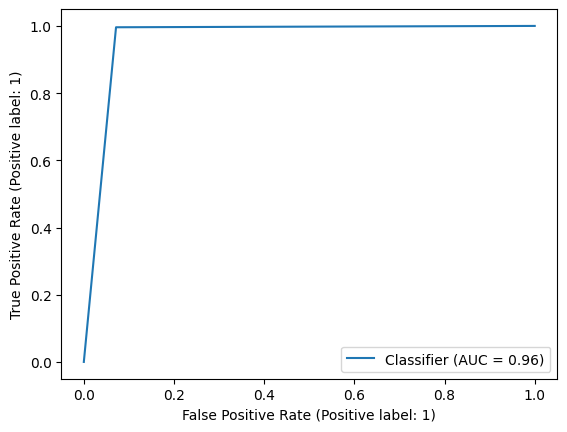

In [689]:
RocCurveDisplay.from_predictions(y_test, y_pred)

In [691]:
!python --version

Python 3.10.6


In [694]:
torch.__version__

'1.12.1+cu116'